In [1]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
from fpm_2 import make_model
import scipy.sparse

model = make_model()
model.prepare_simulation()
# pp.run_time_dependent_model(
#     model, {"prepare_simulation": False, "progressbars": True}
# )

# pp.plot_grid(
#     model.mdg,
#     cell_value=model.pressure_variable,
#     vector_value=model.displacement_variable,
#     alpha=0.5,
# )

model.time_manager.increase_time()
model.time_manager.increase_time_index()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model.assemble_linear_system()
mat, rhs = model.linear_system
# spy(mat)
# plt.show()
# plot_mat(mat)
# plt.show()

model._initialize_solver()
block_matrix = make_block_mat(model, mat)
eq_blocks = model.make_equations_indices()
var_blocks = model.make_variables_indices()

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange  # type: ignore


In [2]:
model.sticking_sliding_open()

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

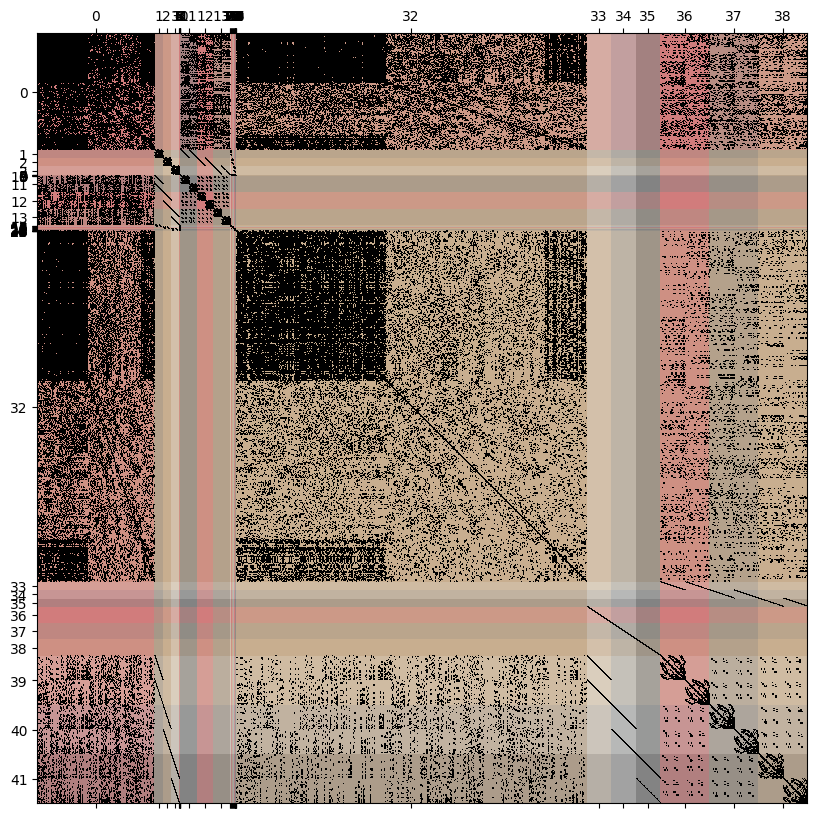

In [3]:
plt.figure(figsize=(10, 10))
color_spy(block_mat=block_matrix)

In [4]:
A = concatenate_blocks(block_matrix, eq_blocks[0], var_blocks[0])
C1 = concatenate_blocks(block_matrix, eq_blocks[0], var_blocks[1])
C2 = concatenate_blocks(block_matrix, eq_blocks[1], var_blocks[0])
B = concatenate_blocks(block_matrix, eq_blocks[1], var_blocks[1])
D1 = concatenate_blocks(block_matrix, eq_blocks[0], var_blocks[2])
E1 = concatenate_blocks(block_matrix, eq_blocks[1], var_blocks[2])
D2 = concatenate_blocks(block_matrix, eq_blocks[2], var_blocks[0])
E2 = concatenate_blocks(block_matrix, eq_blocks[2], var_blocks[1])
F = concatenate_blocks(block_matrix, eq_blocks[2], var_blocks[2])
Phi = bmat([[E2, D2]])

# zeros_diag = F.diagonal() == 0
# ones = scipy.sparse.eye(F.shape[0], format='csr')
# ones.data[:] = zeros_diag
# F_inv = inv(F + ones)

F_inv = inv(F)

# F_inv = scipy.sparse.csr_matrix(np.linalg.pinv(F.A))


D1_Finv_D2 = D1 @ F_inv @ D2
E1_Finv_D2 = E1 @ F_inv @ D2
D1_Finv_E2 = D1 @ F_inv @ E2
E1_Finv_E2 = E1 @ F_inv @ E2

Ap = A - D1_Finv_D2
Bp = B - E1_Finv_E2
C1p = C1 - D1_Finv_E2
C2p = C2 - E1_Finv_D2

Bp_amg = PetscAMGMechanics(mat=Bp, dim=model.nd)
# Bp_inv = inv(Bp)

S_Ap_fs = Ap + get_fixed_stress_stabilization(model)

S_Ap_fs_amg = PetscAMGFlow(S_Ap_fs)
# S_Ap_fs_inv = inv(S_Ap_fs)

Omega_p_amg_fstress = OmegaInv(
    solve_momentum=Bp_amg, solve_mass=S_Ap_fs_amg, C1=C1p, C2=C2p
)

# Omega_p_inv_fstress = OmegaInv(
#     solve_momentum=Bp_inv, solve_mass=S_Ap_fs_inv, C1=C1p, C2=C2p
# )

prec_fstress_amg = UpperBlockPreconditioner(
    F_inv=F_inv, Omega_inv=Omega_p_amg_fstress, Phi=Phi
)

# prec_fstress_inv = UpperBlockPreconditioner(
#     F_inv=F_inv, Omega_inv=Omega_p_inv_fstress, Phi=Phi
# )

permutation = make_permutations(
            model.eq_dofs, order=eq_blocks[2] + eq_blocks[1] + eq_blocks[0]
        )
permuted_mat = permutation @ mat @ model.permutation.T

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Solve B amg took: 1.14
Solve S_A amg took: 0.05
Solve fstress amg took: 2.57


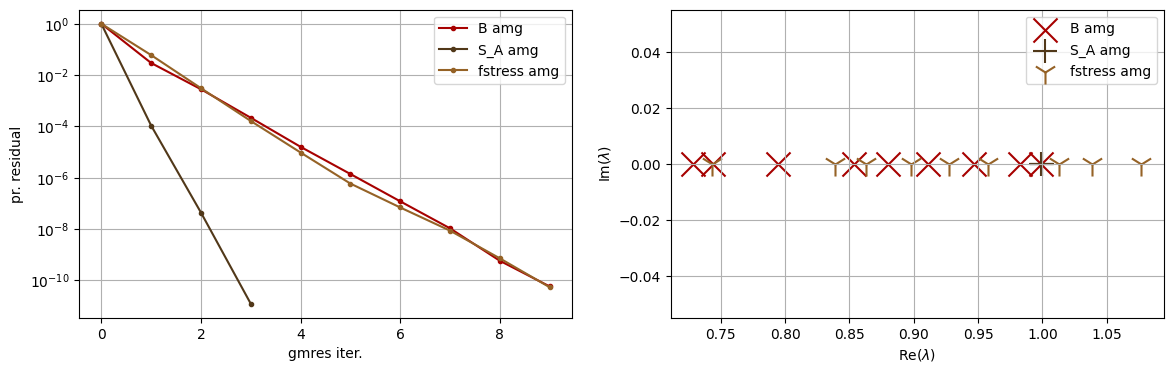

In [5]:
solve_petsc(Bp, Bp_amg, label='B amg')
solve_petsc(S_Ap_fs, S_Ap_fs_amg, label='S_A amg')
solve_petsc(permuted_mat, prec_fstress_amg, logx_eigs=False, label='fstress amg')

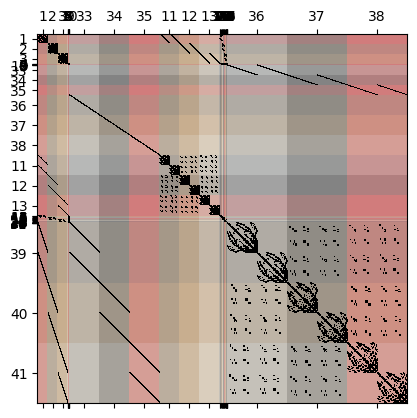

In [6]:
dim_max = model.mdg.dim_max()
sd_ambient = model.mdg.subdomains(dim=dim_max)
sd_lower = [k for i in reversed(range(0, dim_max)) for k in model.mdg.subdomains(dim=i)]
sd_frac = model.mdg.subdomains(dim=dim_max - 1)
intf = model.mdg.interfaces()
intf_frac = model.mdg.interfaces(dim=dim_max - 1)

var_idx = get_variables_indices(
    variable_to_idx=make_variable_to_idx(model),
    md_variables_groups=[
        [model.pressure(sd_ambient)],
        [model.displacement(sd_ambient)],
        [model.pressure(sd_lower)],
        [model.contact_traction(sd_frac)],
        [model.interface_darcy_flux(intf)],
        [model.interface_displacement(intf_frac)],
    ],
)

eq_idx = get_equations_indices(
    equation_to_idx=make_equation_to_idx(model),
    equations_group_order=[
        [("mass_balance_equation", sd_ambient)],  # 0
        [("momentum_balance_equation", sd_ambient)],  # 1
        [("mass_balance_equation", sd_lower)],  # 2
        [
            ("normal_fracture_deformation_equation", sd_lower),  # 3
            ("tangential_fracture_deformation_equation", sd_lower),
        ],
        [("interface_darcy_flux_equation", intf)],  # 4
        [("interface_force_balance_equation", intf)],  # 5
    ],
)

# diagnostics = model.run_diagnostics(grouping='dense')
# model.plot_diagnostics(diagnostics, key='max')
# plot_mat(concatenate_blocks(block_matrix, eq_idx[3], var_idx[3]))
color_spy(
    block_matrix,
    eq_idx[2] + eq_idx[3] + eq_idx[4] + eq_idx[5],
    var_idx[2] + var_idx[3] + var_idx[4] + var_idx[5],
)
x = concatenate_blocks(
    block_matrix,
    eq_idx[2] + eq_idx[3] + eq_idx[4] + eq_idx[5],
    var_idx[2] + var_idx[3] + var_idx[4] + var_idx[5],
); plt.show()
# plot_eigs(x)

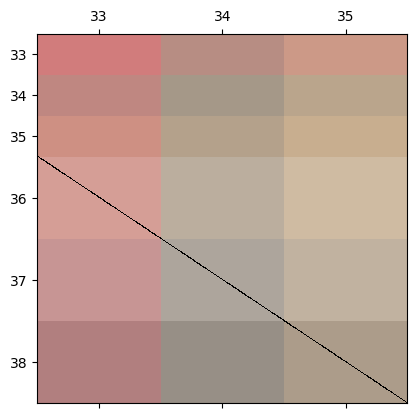

In [7]:
color_spy(
    block_matrix,
    eq_idx[3],
    var_idx[3],
)

In [8]:
# Intf force balance 
from mat_utils import *

F33 = concatenate_blocks(block_matrix, eq_idx[5], var_idx[5])
F33_inv = extract_diag_inv(F33)
# F33_inv = inv(F33)
hor_blocks = [concatenate_blocks(block_matrix, eq_idx[5], var_idx[i]) for i in range(5)]
vert_blocks =  [concatenate_blocks(block_matrix, eq_idx[i], var_idx[5]) for i in range(5)]
stabilizer3 = []
for vert in vert_blocks:
    row = []
    for hor in hor_blocks:
        row.append(-vert @ F33_inv @ hor)
    stabilizer3.append(row)

stabilizer3 = np.array(stabilizer3, dtype=object)
stabilizer3[0, 0].shape

(1486, 1486)

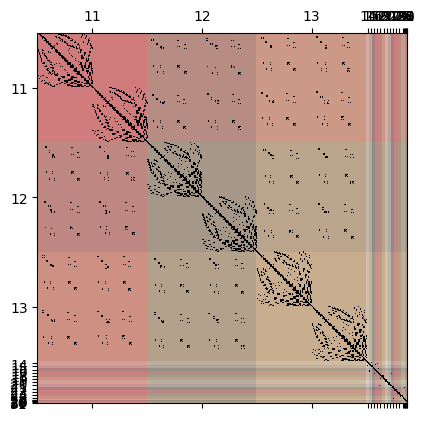

In [14]:
F22 = concatenate_blocks(block_matrix, eq_idx[4], var_idx[4])
S_F22 = F22 + stabilizer3[4, 4]
spy(S_F22, show=False)
color_spy(block_matrix, eq_idx[4], var_idx[4])

Solve  took: 0.0


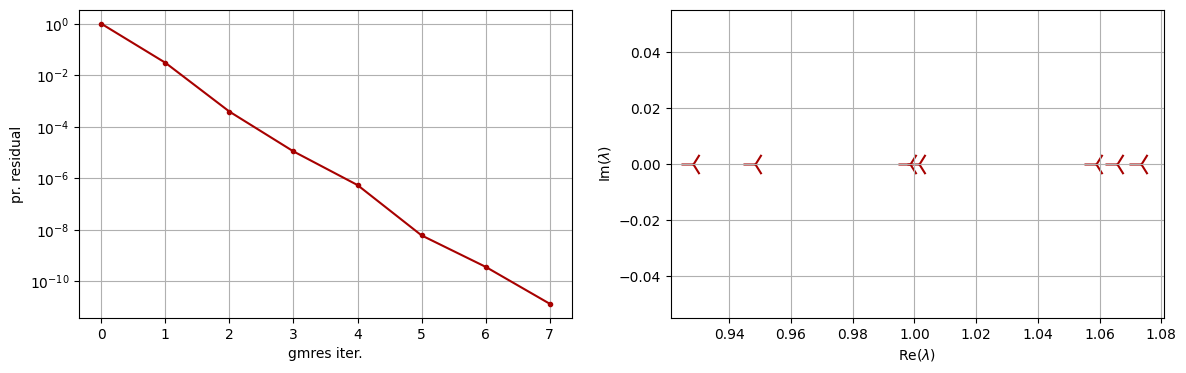

In [15]:
solve_petsc(S_F22, PetscJacobi(S_F22))

In [16]:
S_F2_inv = extract_diag_inv(S_F22)
# F33_inv = inv(F33)
hor_blocks = [concatenate_blocks(block_matrix, eq_idx[4], var_idx[i]) for i in range(4)]
vert_blocks =  [concatenate_blocks(block_matrix, eq_idx[i], var_idx[4]) for i in range(4)]
stabilizer2 = []
for vert in vert_blocks:
    row = []
    for hor in hor_blocks:
        row.append(-vert @ S_F2_inv @ hor)
    stabilizer2.append(row)

stabilizer2 = np.array(stabilizer2, dtype=object)
stabilizer2[3, 3].shape

(936, 936)

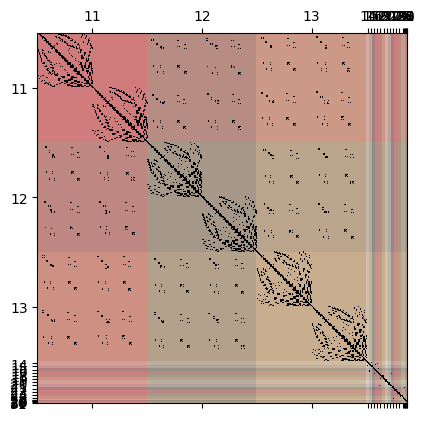

In [17]:
F22 = concatenate_blocks(block_matrix, eq_idx[4], var_idx[4])
S_F22 = F22 + stabilizer3[4, 4]
spy(S_F22, show=False)
color_spy(block_matrix, eq_idx[4], var_idx[4])